# Data Science Group Project

In [58]:
#Install and import libraries
#pip install python-Levenshtein
#pip install folium
#pip install uszipcode
import seaborn as sns
import matplotlib
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
from pandas import Series, DataFrame
import pandas as pd
# Special packages
import statsmodels.api as sm
from patsy import dmatrices
import warnings
warnings.filterwarnings('ignore')
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [59]:
from pandas import Series, DataFrame
import pandas as pd

import random

from numpy import mean, std
import numpy as np

import math

import statsmodels.api as sm

from patsy import dmatrices

from sklearn import tree
from sklearn import neighbors
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold, RepeatedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_regression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor

from pprint import pprint


## Data Loading

#### Loading Austin ZIP codes

In [60]:
#load list of zips in Austin
only_Austin_zips_df = pd.read_csv('list_zips_Austin.csv', dtype=str)
Austin_zips_df=only_Austin_zips_df

In [61]:
#pip install uszipcode

#### Education database from https://pypi.org/project/uszipcode/

In [62]:
#create Education database from API
import json
import uszipcode
from uszipcode import SearchEngine
engine = SearchEngine(simple_or_comprehensive=SearchEngine.SimpleOrComprehensiveArgEnum.comprehensive)

df_edu = pd.DataFrame([])

def processing_function(input_zip):
    global df_edu
    df= pd.DataFrame([])
    zipcode = engine.by_zipcode(input_zip)
    details = zipcode.to_dict()
    #print(details)
    try:
      df = pd.json_normalize(details['educational_attainment_for_population_25_and_over'], record_path =['values'])
    except:
        x=1
      #print("An exception occurred")
    df['zip']=input_zip
    df_edu=pd.concat([df_edu,df])
    #print(df_edu)
    return df_edu

Austin_education_zips=Austin_zips_df[['zipcode']]
Austin_zips_new=Austin_zips_df['zipcode'].apply(processing_function)
df_edu[:5]


,x,y,zip
0,Less Than High School Diploma,2040.0,78610
1,High School Graduate,7807.0,78610
2,Associate's Degree,1182.0,78610
3,Bachelor's Degree,3801.0,78610
4,Master's Degree,1211.0,78610


In [63]:
#calculate education scores by zip
def weighted_sum(s):
    #print(sum(s))
    return sum(s)

zip_education_scores=df_edu.groupby(['zip'])[['y']].agg([weighted_sum,'count'])

zip_education_cuts = pd.qcut(zip_education_scores['y']['weighted_sum'],4,labels=['High', 'Medium', 'Low','Very Low'])
zip_education_scores['edu_score']=zip_education_cuts
zip_education_scores.columns = zip_education_scores.columns.to_flat_index()
zip_education_scores.reset_index(inplace=True)

zip_education_scores['education_score']=zip_education_scores.iloc[: , -1]
zip_education_scores=zip_education_scores[['zip','education_score']]
zip_education_scores[:5]

,zip,education_score
0,78610,Low
1,78613,Very Low
2,78617,Medium
3,78641,Very Low
4,78652,High


#### Median household income from https://pypi.org/project/uszipcode/

In [64]:
#get median household income
def processing_function_2(input_zip):
    zipcode = engine.by_zipcode(input_zip)
    details = zipcode.median_home_value
    return details

Austin_med_house_val_zips=Austin_zips_df[['zipcode']]
Austin_med_house_val_zips['median_home_value']=Austin_med_house_val_zips['zipcode'].apply(processing_function_2)
Austin_med_house_val_zips[:5]

,zipcode,median_home_value
0,78610,182400.0
1,78613,198900.0
2,78617,99700.0
3,78641,156900.0
4,78652,191200.0


#### Median_home_value , population, population_density,housing_units,land_area_in_sqmi from https://pypi.org/project/uszipcode/

In [66]:
#get median household income
def processing_function_3(input_zip):
    zipcode = engine.by_zipcode(input_zip)
    details = zipcode.median_household_income
    return details
def processing_function_4(input_zip):
    zipcode = engine.by_zipcode(input_zip)
    details = zipcode.population
    return details
def processing_function_5(input_zip):
    zipcode = engine.by_zipcode(input_zip)
    details = zipcode.population_density
    return details
def processing_function_6(input_zip):
    zipcode = engine.by_zipcode(input_zip)
    details = zipcode.housing_units
    return details
def processing_function_7(input_zip):
    zipcode = engine.by_zipcode(input_zip)
    details = zipcode.land_area_in_sqmi
    return details


Austin_med_house_inc_zips=Austin_zips_df[['zipcode']]
Austin_med_house_inc_zips['median_household_income']=Austin_med_house_inc_zips['zipcode'].apply(processing_function_3)
Austin_med_house_inc_zips['population']=Austin_med_house_inc_zips['zipcode'].apply(processing_function_4)
Austin_med_house_inc_zips['population_density']=Austin_med_house_inc_zips['zipcode'].apply(processing_function_5)
Austin_med_house_inc_zips['housing_units']=Austin_med_house_inc_zips['zipcode'].apply(processing_function_6)
Austin_med_house_inc_zips['land_area_in_sqmi']=Austin_med_house_inc_zips['zipcode'].apply(processing_function_7)
Austin_med_house_inc_zips[:5]

,zipcode,median_household_income,population,population_density,housing_units,land_area_in_sqmi
0,78610,79049.0,23502.0,254.0,8184.0,92.38
1,78613,81928.0,65099.0,2318.0,24120.0,28.09
2,78617,45212.0,22210.0,320.0,6027.0,69.39
3,78641,71885.0,44295.0,350.0,15749.0,126.47
4,78652,76604.0,4466.0,258.0,1823.0,17.29


#### Rental Unit list from https://pypi.org/project/uszipcode/

In [68]:
#create rental unit from API
df_rent = pd.DataFrame([])

def processing_function_4(input_zip):
    global df_rent
    df= pd.DataFrame([])
    zipcode = engine.by_zipcode(input_zip)
    details = zipcode.to_dict()
    #print(details)
    try:
      df = pd.json_normalize(details['rental_properties_by_number_of_rooms'], record_path =['values'])
    except:
        x=1
      #print("An exception occurred")
    df['zip']=input_zip
    df_rent=pd.concat([df_rent,df])
    #print(df_rent)
    return df_rent

Austin_rental_units_zips=Austin_zips_df[['zipcode']]
Austin_rental_units_zips_new=Austin_rental_units_zips['zipcode'].apply(processing_function_4)
df_rent=df_rent.rename(columns={'x': "Home Type", "y": "Number of Units"})
df_rent[:5]

,Home Type,Number of Units,zip
0,Studio Apartment,31.0,78610
1,1 Bedroom,248.0,78610
2,2 Bedroom,335.0,78610
3,3+ Bedroom,831.0,78610
0,Studio Apartment,204.0,78613


#### Get public transport data from https://pypi.org/project/uszipcode/ 

In [69]:
#create public transport unit from API
df_public_transport = pd.DataFrame([])

def processing_function_8(input_zip):
    global df_public_transport
    df= pd.DataFrame([])
    zipcode = engine.by_zipcode(input_zip)
    details = zipcode.to_dict()
    try:
      df = pd.json_normalize(details['means_of_transportation_to_work_for_workers_16_and_over'], record_path =['values'])
    except:
      #print("An exception occurred")
        x=1
    df['zip']=input_zip
    df_public_transport=pd.concat([df_public_transport,df])
    return df_public_transport

Austin_rental_units_zips=Austin_zips_df[['zipcode']]
Austin_rental_units_zips_new=Austin_rental_units_zips['zipcode'].apply(processing_function_8)

df_public_transport=df_public_transport[df_public_transport['x']=='Public Transportation']
df_public_transport=df_public_transport.rename(columns={'x': "Transport", "y": "Number of Units"})
df_public_transport

zip_transport_scores=df_public_transport.groupby(['zip'])[['Number of Units']].agg(['sum'])

zip_transport_cuts = pd.qcut(zip_transport_scores['Number of Units']['sum'].rank(method='first'),4,labels=['High', 'Medium', 'Low','Very Low'])
zip_transport_scores['transport_score']=zip_transport_cuts
zip_transport_scores.columns = zip_transport_scores.columns.to_flat_index()
zip_transport_scores.reset_index(inplace=True)

zip_transport_scores['transport_score']=zip_transport_scores.iloc[: , -1]
zip_transport_scores=zip_transport_scores[['zip','transport_score']]
zip_transport_scores[:5]

,zip,transport_score
0,78610,High
1,78613,Low
2,78617,Medium
3,78641,Medium
4,78652,High


#### Rent Current and time series from https://www.zillow.com/research/data/

In [70]:
rent_zips_df = pd.read_csv('Zip_ZORI_AllHomesPlusMultifamily_Smoothed.csv', dtype=str)

Austin_rent_zips_df=rent_zips_df.merge(Austin_zips_df, left_on='RegionName', right_on='zipcode')
Austin_rent_zips_df_zx=Austin_rent_zips_df.set_index('zipcode')
Austin_rent_zips_df_zx_new=Austin_rent_zips_df_zx.drop(['RegionID','RegionName','SizeRank','MsaName'], axis=1)
Austin_rent_zips_df_zx_new_T=Austin_rent_zips_df_zx_new.T

Austin_rent_zips_df_zx_new_T.index = pd.to_datetime(Austin_rent_zips_df_zx_new_T.index)
Austin_rent_zips_df_zx_new_T.sort_index(inplace=True)
Austin_rent_zips_df_zx_new_T

#timeseries rent data
Austin_rent_zips_df_zx_new_T = Austin_rent_zips_df_zx_new_T.apply(pd.to_numeric, errors='coerce')

#rent data to get current rent for zips
zips_current_rent=Austin_rent_zips_df_zx_new_T.loc[Austin_rent_zips_df_zx_new_T.index.max()]
zips_current_rent=pd.DataFrame([zips_current_rent])
zips_current_rent_T=zips_current_rent.T

Austin_rent_current=zips_current_rent_T.merge(Austin_zips_df, left_on='zipcode', right_on='zipcode')
Austin_rent_current['current_rent']=Austin_rent_current.iloc[: , -1]
Austin_rent_current=Austin_rent_current[['zipcode','current_rent']]
Austin_rent_current[:5]

,zipcode,current_rent
0,78660,1748.0
1,78613,1882.0
2,78704,2301.0
3,78745,1733.0
4,78641,1915.0


#### Coding the ZIP data into Map friendly Format

In [71]:
#merge all datasets
#merge education scores
merged_dataset_1=Austin_zips_df.merge(zip_education_scores, left_on='zipcode', right_on='zip',how='left')
clean_dataset_1=merged_dataset_1[['zipcode','education_score']]

#merge to get home value
merged_dataset_2=clean_dataset_1.merge(Austin_med_house_val_zips, left_on='zipcode', right_on='zipcode',how='left')
clean_dataset_2=merged_dataset_2[['zipcode','education_score','median_home_value']]

#merge to get home income
merged_dataset_3=clean_dataset_2.merge(Austin_med_house_inc_zips, left_on='zipcode', right_on='zipcode',how='left')
clean_dataset_3=merged_dataset_3[['zipcode','education_score','median_home_value','median_household_income','population', 'population_density','housing_units','land_area_in_sqmi']]

#merge to get current rent
merged_dataset_4=clean_dataset_3.merge(Austin_rent_current, left_on='zipcode', right_on='zipcode',how='left')
clean_dataset_4=merged_dataset_4[['zipcode','education_score','median_home_value','median_household_income','current_rent','population', 'population_density','housing_units','land_area_in_sqmi']]

#merge to get public transport
merged_dataset_5=clean_dataset_4.merge(zip_transport_scores, left_on='zipcode', right_on='zip',how='left')
clean_dataset_5=merged_dataset_5[['zipcode','education_score','median_home_value','median_household_income','current_rent','population', 'population_density','housing_units','land_area_in_sqmi','transport_score']]

tdf=clean_dataset_5

#### Loading the Austin Housing Data

In [72]:
Austin_housing_data = pd.read_csv('austinHousingData.csv', dtype=str)

Austin_housing_data_zip=Austin_housing_data.merge(clean_dataset_5, left_on='zipcode', right_on='zipcode',how='left',suffixes=(False, '_zip'))

#drop non relevant columns
Austin_housing_data_zip_clean=Austin_housing_data_zip.drop(['description', 'hasAssociation', 'numPriceChanges', 'latest_saledate', 
                                                            'latest_saleyear', 'latestPriceSource', 'numOfPhotos', 'homeImage', 
                                                            'population_density','housing_units','land_area_in_sqmi'], axis=1)
Austin_housing_data_zip_clean.columns

Index(['zpid', 'city', 'streetAddress', 'zipcode', 'latitude', 'longitude',
       'propertyTaxRate', 'garageSpaces', 'hasCooling', 'hasGarage',
       'hasHeating', 'hasSpa', 'hasView', 'homeType', 'parkingSpaces',
       'yearBuilt', 'latestPrice', 'latest_salemonth',
       'numOfAccessibilityFeatures', 'numOfAppliances', 'numOfParkingFeatures',
       'numOfPatioAndPorchFeatures', 'numOfSecurityFeatures',
       'numOfWaterfrontFeatures', 'numOfWindowFeatures',
       'numOfCommunityFeatures', 'lotSizeSqFt', 'livingAreaSqFt',
       'numOfPrimarySchools', 'numOfElementarySchools', 'numOfMiddleSchools',
       'numOfHighSchools', 'avgSchoolDistance', 'avgSchoolRating',
       'avgSchoolSize', 'MedianStudentsPerTeacher', 'numOfBathrooms',
       'numOfBedrooms', 'numOfStories', 'education_score', 'median_home_value',
       'median_household_income', 'current_rent', 'population',
       'transport_score'],
      dtype='object')

***

## EDA

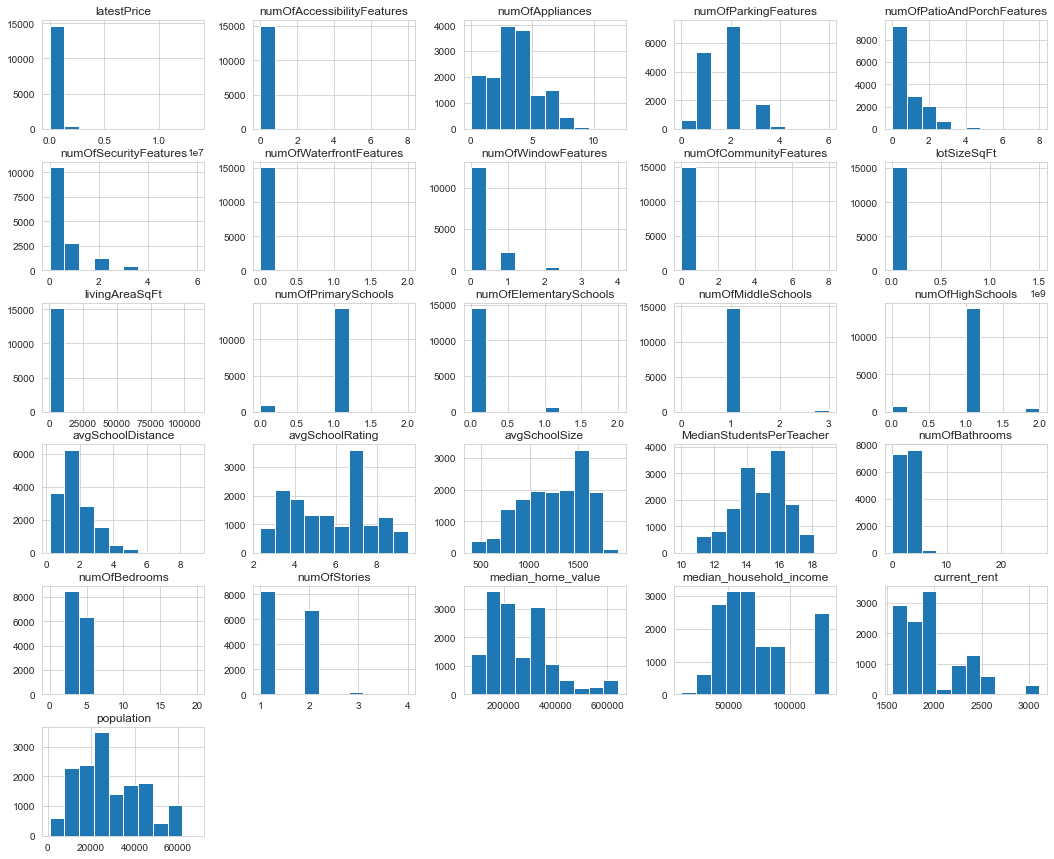

In [74]:
#print('\n\n_______________\n\n',Austin_housing_data_zip_2.dtypes)
Austin_housing_data_zip_2=Austin_housing_data_zip_clean.astype({"latestPrice": float, 
                                                                "numOfAccessibilityFeatures": float,
                                                               "numOfAppliances": float, 
                                                               "numOfParkingFeatures": float, 
                                                               "numOfPatioAndPorchFeatures": float, 
                                                               "numOfSecurityFeatures": float, 
                                                               "numOfWaterfrontFeatures": float, 
                                                               "numOfWindowFeatures": float, 
                                                               "numOfCommunityFeatures": float, 
                                                               "lotSizeSqFt": float,
                                                               "livingAreaSqFt": float,
                                                               "numOfPrimarySchools": float,
                                                               "numOfElementarySchools": float,
                                                               "numOfMiddleSchools": float,
                                                               "numOfHighSchools": float,
                                                               "avgSchoolDistance": float,
                                                               "avgSchoolSize": float,
                                                               "avgSchoolRating": float,
                                                               "avgSchoolSize": float,
                                                               "MedianStudentsPerTeacher": float,
                                                               "numOfBathrooms": float,
                                                               "numOfBedrooms": float,
                                                               "numOfStories": float})
Austin_housing_data_zip_2.hist(figsize=(18,15));

In [75]:
#Initial exploration of data
Austin_housing_data_zip_2.head()
Austin_housing_data_zip_2.tail()
Austin_housing_data_zip_2.shape

(15171, 45)

In [76]:
#converting boolean to 0/1 values
Austin_housing_data_zip_2['hasCooling'] = Austin_housing_data_zip_2['hasCooling'].apply( lambda x: 1 if x == True else 0)
Austin_housing_data_zip_2['hasGarage'] = Austin_housing_data_zip_2['hasGarage'].apply( lambda x: 1 if x == True else 0)
Austin_housing_data_zip_2['hasHeating'] = Austin_housing_data_zip_2['hasHeating'].apply( lambda x: 1 if x == True else 0)
Austin_housing_data_zip_2['hasSpa'] = Austin_housing_data_zip_2['hasSpa'].apply( lambda x: 1 if x == True else 0)
Austin_housing_data_zip_2['hasView'] = Austin_housing_data_zip_2['hasView'].apply( lambda x: 1 if x == True else 0)
Austin_housing_data_zip_2

,zpid,city,streetAddress,zipcode,latitude,longitude,propertyTaxRate,garageSpaces,hasCooling,hasGarage,...,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories,education_score,median_home_value,median_household_income,current_rent,population,transport_score
0,111373431,pflugerville,14424 Lake Victor Dr,78660,30.43063163757324,-97.66307830810548,1.98,2,0,0,...,14.0,3.0,4.0,2.0,Very Low,165700.0,76007.0,1748.0,68789.0,Low
1,120900430,pflugerville,1104 Strickling Dr,78660,30.43267250061035,-97.66169738769531,1.98,2,0,0,...,14.0,2.0,4.0,1.0,Very Low,165700.0,76007.0,1748.0,68789.0,Low
2,2084491383,pflugerville,1408 Fort Dessau Rd,78660,30.409748077392567,-97.6397705078125,1.98,0,0,0,...,14.0,2.0,3.0,1.0,Very Low,165700.0,76007.0,1748.0,68789.0,Low
3,120901374,pflugerville,1025 Strickling Dr,78660,30.432111740112305,-97.66165924072266,1.98,2,0,0,...,14.0,2.0,3.0,1.0,Very Low,165700.0,76007.0,1748.0,68789.0,Low
4,60134862,pflugerville,15005 Donna Jane Loop,78660,30.437368392944336,-97.6568603515625,1.98,0,0,0,...,14.0,3.0,3.0,2.0,Very Low,165700.0,76007.0,1748.0,68789.0,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15166,29512934,austin,905 Silcantu Dr,78748,30.161996841430664,-97.81634521484376,1.98,6,0,0,...,14.0,2.0,3.0,1.0,Very Low,187900.0,66309.0,1690.0,40651.0,Low
15167,241937773,austin,1413 Waterloo Shore Ln UNIT 12,78741,30.240222930908203,-97.77283477783205,1.98,2,0,0,...,16.0,4.0,3.0,3.0,Very Low,127500.0,30871.0,1690.0,44935.0,Very Low
15168,29473281,austin,2206 S 3rd St,78704,30.244834899902344,-97.76112365722656,1.98,2,0,0,...,13.0,3.0,3.0,2.0,Very Low,347500.0,50930.0,2301.0,42117.0,Very Low
15169,29392029,austin,2000 Chestnut Ave,78722,30.28156852722168,-97.71778869628906,1.98,0,0,0,...,15.0,2.0,4.0,1.0,High,279200.0,50923.0,NaN,5901.0,Low


In [77]:
print('Categorical Column name')
for col in Austin_housing_data_zip_2.columns:
    if Austin_housing_data_zip_2[col].dtype=='object':
        print(col, Austin_housing_data_zip_2[col].nunique())

Categorical Column name
zpid 15171
city 9
streetAddress 15164
zipcode 48
latitude 14410
longitude 12480
propertyTaxRate 3
garageSpaces 14
homeType 10
parkingSpaces 14
yearBuilt 115
latest_salemonth 12


In [78]:
#combining school counts
Austin_housing_data_zip_2['numOfSchools'] = Austin_housing_data_zip_2['numOfPrimarySchools'] + Austin_housing_data_zip_2['numOfElementarySchools'] + Austin_housing_data_zip_2['numOfMiddleSchools'] + Austin_housing_data_zip_2['numOfHighSchools']
Austin_housing_data_zip_2[:10]

,zpid,city,streetAddress,zipcode,latitude,longitude,propertyTaxRate,garageSpaces,hasCooling,hasGarage,...,numOfBathrooms,numOfBedrooms,numOfStories,education_score,median_home_value,median_household_income,current_rent,population,transport_score,numOfSchools
0,111373431,pflugerville,14424 Lake Victor Dr,78660,30.43063163757324,-97.66307830810548,1.98,2,0,0,...,3.0,4.0,2.0,Very Low,165700.0,76007.0,1748.0,68789.0,Low,3.0
1,120900430,pflugerville,1104 Strickling Dr,78660,30.43267250061035,-97.66169738769531,1.98,2,0,0,...,2.0,4.0,1.0,Very Low,165700.0,76007.0,1748.0,68789.0,Low,3.0
2,2084491383,pflugerville,1408 Fort Dessau Rd,78660,30.409748077392567,-97.6397705078125,1.98,0,0,0,...,2.0,3.0,1.0,Very Low,165700.0,76007.0,1748.0,68789.0,Low,4.0
3,120901374,pflugerville,1025 Strickling Dr,78660,30.432111740112305,-97.66165924072266,1.98,2,0,0,...,2.0,3.0,1.0,Very Low,165700.0,76007.0,1748.0,68789.0,Low,3.0
4,60134862,pflugerville,15005 Donna Jane Loop,78660,30.437368392944336,-97.6568603515625,1.98,0,0,0,...,3.0,3.0,2.0,Very Low,165700.0,76007.0,1748.0,68789.0,Low,3.0
5,2080105342,pflugerville,14908 Spring Hill Ln,78660,30.437774658203125,-97.65618133544922,1.98,2,0,0,...,2.0,3.0,1.0,Very Low,165700.0,76007.0,1748.0,68789.0,Low,3.0
6,241932337,pflugerville,14009 Cantata Ln,78660,30.414684295654297,-97.64339447021484,1.98,0,0,0,...,3.0,4.0,2.0,Very Low,165700.0,76007.0,1748.0,68789.0,Low,3.0
7,60134835,pflugerville,15009 Drusillas Dr,78660,30.43940353393555,-97.65803527832031,1.98,0,0,0,...,3.0,3.0,2.0,Very Low,165700.0,76007.0,1748.0,68789.0,Low,3.0
8,60134833,pflugerville,1104 Traci Michelle Dr,78660,30.439096450805664,-97.657958984375,1.98,0,0,0,...,2.0,3.0,2.0,Very Low,165700.0,76007.0,1748.0,68789.0,Low,3.0
9,83827468,del valle,6808 Plains Crest Dr,78617,30.160701751708984,-97.63812255859376,1.98,2,0,0,...,3.0,3.0,2.0,Medium,99700.0,45212.0,NaN,22210.0,Medium,3.0


In [79]:
#dropping outliers

Austin_housing_data_zip_2.drop(Austin_housing_data_zip_2[Austin_housing_data_zip_2['latestPrice'] > 3000000].index, inplace = True)
Austin_housing_data_zip_2.drop(Austin_housing_data_zip_2[Austin_housing_data_zip_2['latestPrice'] < 75000].index, inplace = True)
Austin_housing_data_zip_2.drop(Austin_housing_data_zip_2[Austin_housing_data_zip_2['numOfBedrooms'] > 8.0].index, inplace = True)
Austin_housing_data_zip_2.drop(Austin_housing_data_zip_2[Austin_housing_data_zip_2['numOfAppliances'] > 10.0].index, inplace = True)
Austin_housing_data_zip_2.drop(Austin_housing_data_zip_2[Austin_housing_data_zip_2['numOfSchools'] > 4.0].index, inplace = True)
Austin_housing_data_zip_2.drop(Austin_housing_data_zip_2[Austin_housing_data_zip_2['numOfAccessibilityFeatures'] > 5.0].index, inplace = True)
Austin_housing_data_zip_2.drop(Austin_housing_data_zip_2[Austin_housing_data_zip_2['numOfPatioAndPorchFeatures'] > 7.0].index, inplace = True)
Austin_housing_data_zip_2.drop(Austin_housing_data_zip_2[Austin_housing_data_zip_2['numOfWindowFeatures'] > 3.0].index, inplace = True)


Maximum House prices : /n [2999000. 2995000. 2995000. 2995000. 2995000.]


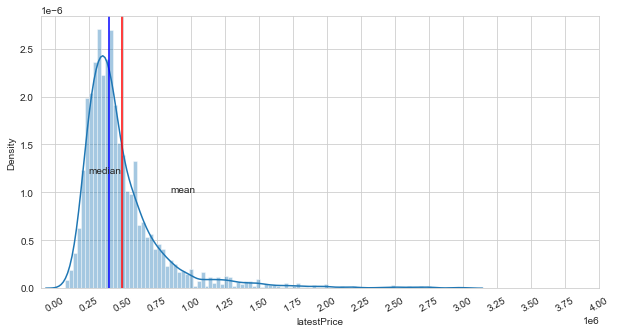

In [81]:
# house prices greater than 3 mln probably represents outliers.
import matplotlib.ticker as ticker

print('Maximum House prices : /n',Austin_housing_data_zip_2['latestPrice'].sort_values(ascending=False)[:5].values)
sns.set_style("whitegrid")
plt.figure(figsize=(10,5))
plotd = sns.distplot(Austin_housing_data_zip_2[(Austin_housing_data_zip_2['latestPrice']>100) & (Austin_housing_data_zip_2['latestPrice'] < 14000000)]['latestPrice'], kde=True, bins=100)

tick_spacing=250000 # set spacing for each tick
plotd.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
plotd.set_xlim([-100000, 4000000]) # do not show negative values 
plt.xticks(rotation=30) # rotate x ticks by 30 degrees
plt.axvline(Austin_housing_data_zip_2[(Austin_housing_data_zip_2['latestPrice']>100) & (Austin_housing_data_zip_2['latestPrice'] < 14000000)]['latestPrice'].mean(), c='red')
plt.axvline(Austin_housing_data_zip_2[(Austin_housing_data_zip_2['latestPrice']>100) & (Austin_housing_data_zip_2['latestPrice'] < 14000000)]['latestPrice'].median(), c='blue')
plt.text(250000,0.0000012, "median")
plt.text(850000,0.0000010, "mean")
plt.show()

In [82]:
# look for nulls dropping all NAs (other than rows from current rent) 
print(Austin_housing_data_zip_2.isna().sum())
Austin_housing_data_zip_3 = Austin_housing_data_zip_2.dropna(subset=['education_score', 'median_home_value'])
print(Austin_housing_data_zip_3.isna().sum())

zpid                             0
city                             0
streetAddress                    0
zipcode                          0
latitude                         0
longitude                        0
propertyTaxRate                  0
garageSpaces                     0
hasCooling                       0
hasGarage                        0
hasHeating                       0
hasSpa                           0
hasView                          0
homeType                         0
parkingSpaces                    0
yearBuilt                        0
latestPrice                      0
latest_salemonth                 0
numOfAccessibilityFeatures       0
numOfAppliances                  0
numOfParkingFeatures             0
numOfPatioAndPorchFeatures       0
numOfSecurityFeatures            0
numOfWaterfrontFeatures          0
numOfWindowFeatures              0
numOfCommunityFeatures           0
lotSizeSqFt                      0
livingAreaSqFt                   0
numOfPrimarySchools 

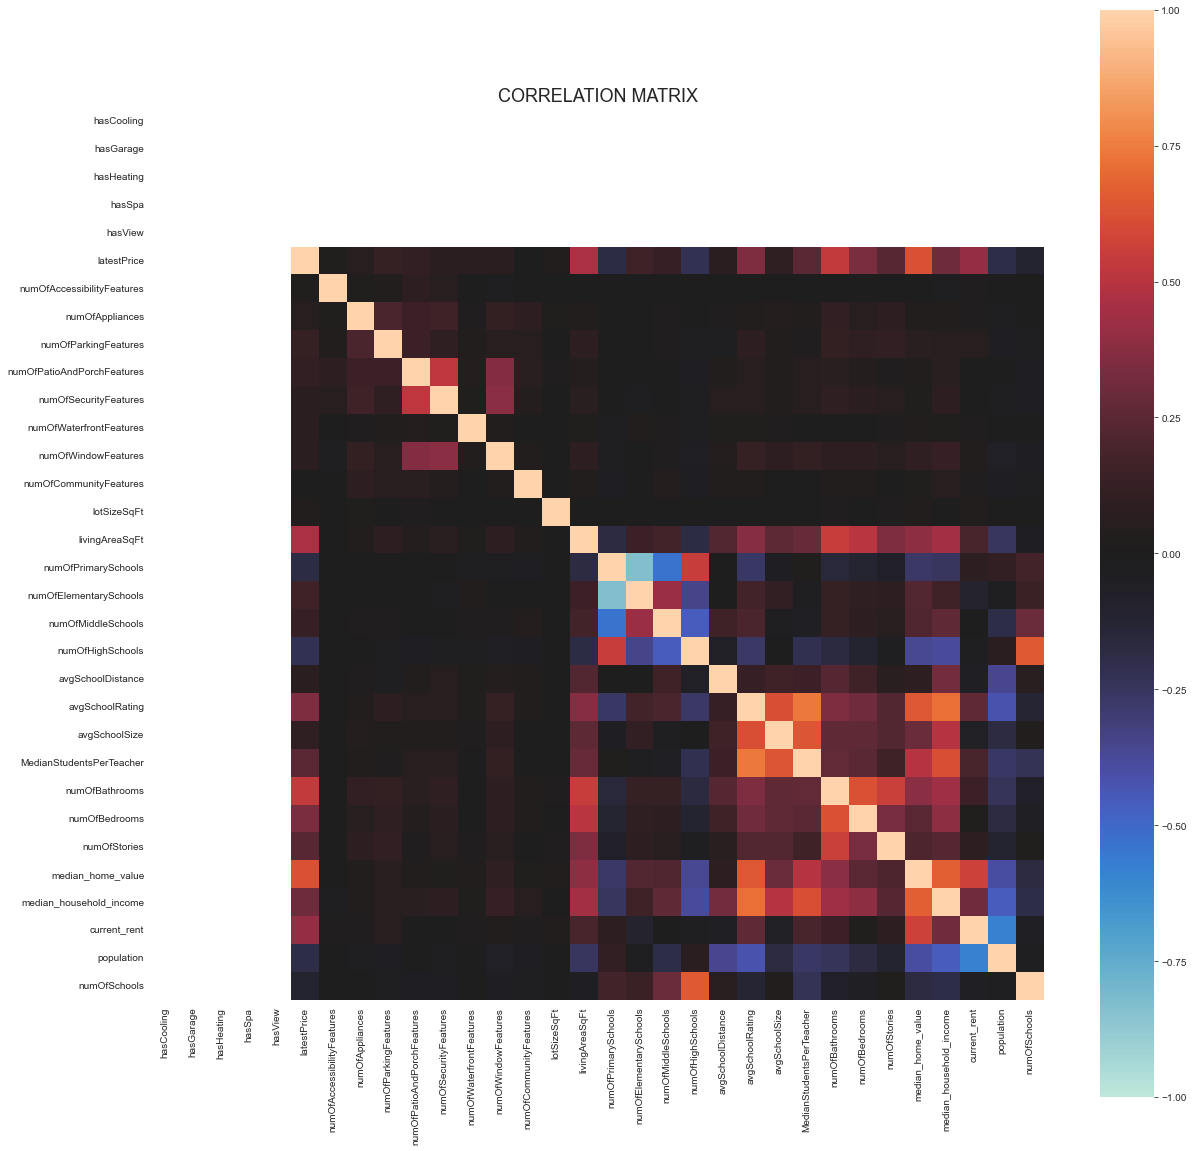

In [83]:
# look for multicollinearity of features
fig, ax = plt.subplots(figsize=(20, 20))

sns.heatmap(Austin_housing_data_zip_2.corr(), center=0,  
           vmin=-1, vmax=1,  square=True)

# title
plt.title('CORRELATION MATRIX', fontsize=18)

plt.show()

In [84]:
correlation=Austin_housing_data_zip_2.corr()
data=pd.DataFrame(correlation['latestPrice'].sort_values(ascending=False))
data.style.apply(lambda x: ["background: Orange" if v > 0.4 else "" for v in x], axis = 1)

,latestPrice
latestPrice,1.000000
median_home_value,0.617535
numOfBathrooms,0.536450
livingAreaSqFt,0.462937
current_rent,0.403949
avgSchoolRating,0.350784
numOfBedrooms,0.342011
median_household_income,0.297106
MedianStudentsPerTeacher,0.248275
numOfStories,0.236244


In [85]:
# Combine the school counts 
Austin_housing_data_zip_2['numOfSchools'] = Austin_housing_data_zip_2['numOfPrimarySchools'] + Austin_housing_data_zip_2['numOfElementarySchools'] + Austin_housing_data_zip_2['numOfMiddleSchools'] + Austin_housing_data_zip_2['numOfHighSchools']
Austin_housing_data_zip_2[:10]

,zpid,city,streetAddress,zipcode,latitude,longitude,propertyTaxRate,garageSpaces,hasCooling,hasGarage,...,numOfBathrooms,numOfBedrooms,numOfStories,education_score,median_home_value,median_household_income,current_rent,population,transport_score,numOfSchools
0,111373431,pflugerville,14424 Lake Victor Dr,78660,30.43063163757324,-97.66307830810548,1.98,2,0,0,...,3.0,4.0,2.0,Very Low,165700.0,76007.0,1748.0,68789.0,Low,3.0
1,120900430,pflugerville,1104 Strickling Dr,78660,30.43267250061035,-97.66169738769531,1.98,2,0,0,...,2.0,4.0,1.0,Very Low,165700.0,76007.0,1748.0,68789.0,Low,3.0
2,2084491383,pflugerville,1408 Fort Dessau Rd,78660,30.409748077392567,-97.6397705078125,1.98,0,0,0,...,2.0,3.0,1.0,Very Low,165700.0,76007.0,1748.0,68789.0,Low,4.0
3,120901374,pflugerville,1025 Strickling Dr,78660,30.432111740112305,-97.66165924072266,1.98,2,0,0,...,2.0,3.0,1.0,Very Low,165700.0,76007.0,1748.0,68789.0,Low,3.0
4,60134862,pflugerville,15005 Donna Jane Loop,78660,30.437368392944336,-97.6568603515625,1.98,0,0,0,...,3.0,3.0,2.0,Very Low,165700.0,76007.0,1748.0,68789.0,Low,3.0
5,2080105342,pflugerville,14908 Spring Hill Ln,78660,30.437774658203125,-97.65618133544922,1.98,2,0,0,...,2.0,3.0,1.0,Very Low,165700.0,76007.0,1748.0,68789.0,Low,3.0
6,241932337,pflugerville,14009 Cantata Ln,78660,30.414684295654297,-97.64339447021484,1.98,0,0,0,...,3.0,4.0,2.0,Very Low,165700.0,76007.0,1748.0,68789.0,Low,3.0
7,60134835,pflugerville,15009 Drusillas Dr,78660,30.43940353393555,-97.65803527832031,1.98,0,0,0,...,3.0,3.0,2.0,Very Low,165700.0,76007.0,1748.0,68789.0,Low,3.0
8,60134833,pflugerville,1104 Traci Michelle Dr,78660,30.439096450805664,-97.657958984375,1.98,0,0,0,...,2.0,3.0,2.0,Very Low,165700.0,76007.0,1748.0,68789.0,Low,3.0
9,83827468,del valle,6808 Plains Crest Dr,78617,30.160701751708984,-97.63812255859376,1.98,2,0,0,...,3.0,3.0,2.0,Medium,99700.0,45212.0,NaN,22210.0,Medium,3.0


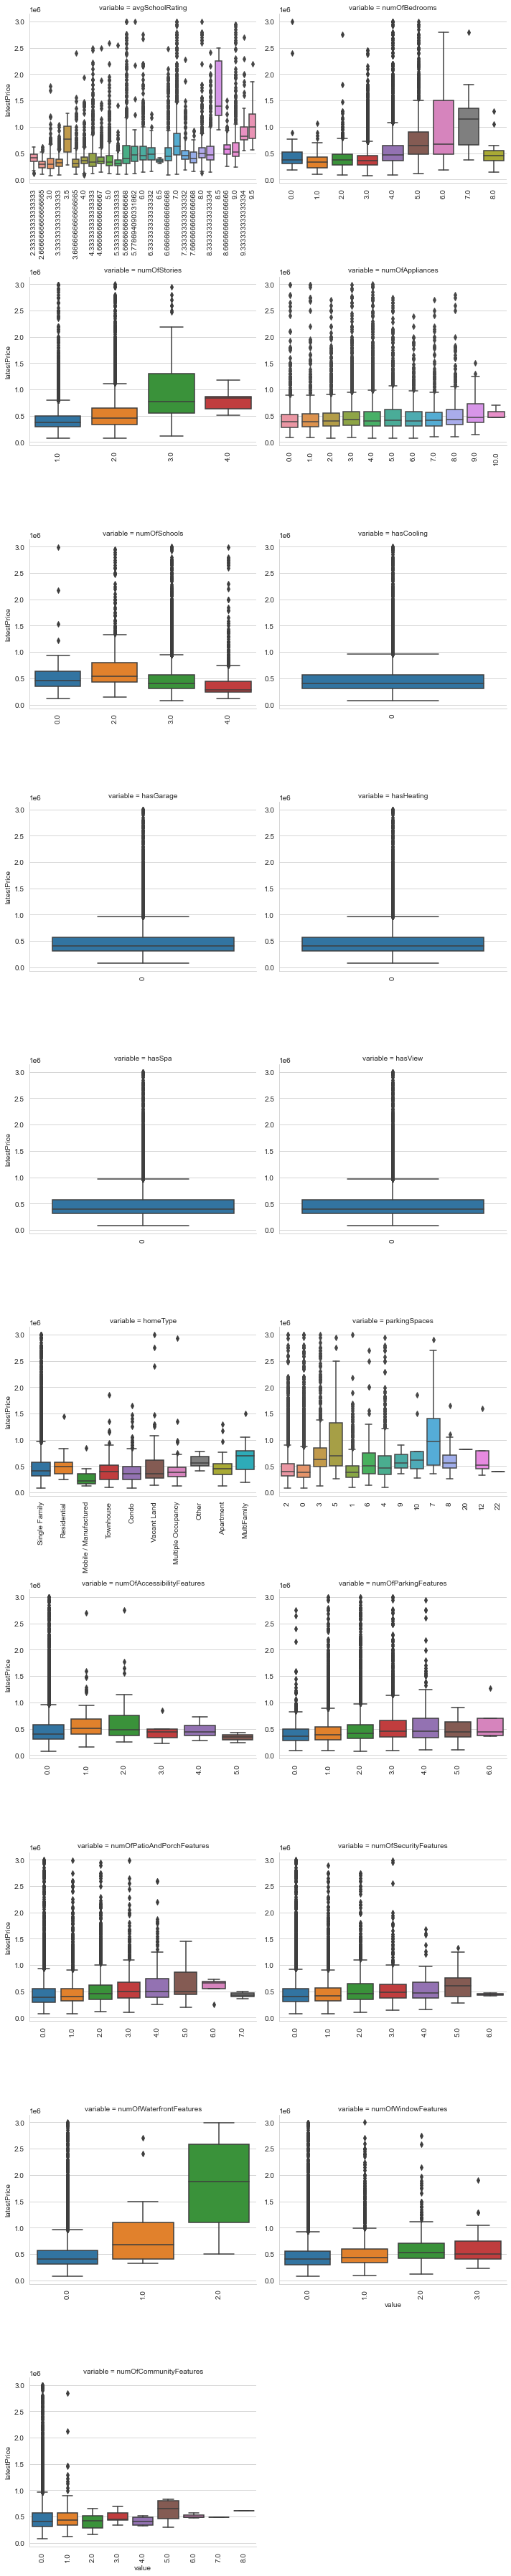

In [86]:
small_cont = ['avgSchoolRating', 'numOfBedrooms', 
              'numOfStories', 'numOfAppliances', 
              'numOfSchools','hasCooling', 'hasGarage',
              'hasHeating', 'hasSpa', 'hasView', 'homeType', 'parkingSpaces',
              'numOfAccessibilityFeatures', 'numOfAppliances', 'numOfParkingFeatures',
              'numOfPatioAndPorchFeatures', 'numOfSecurityFeatures',
              'numOfWaterfrontFeatures', 'numOfWindowFeatures',
              'numOfCommunityFeatures']

# plot our continuous as box plots vs price
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)

f = pd.melt(Austin_housing_data_zip_2, id_vars=['latestPrice'], value_vars=small_cont)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(boxplot, "value", "latestPrice")

***

## Create Models to Predict Rent

#### Create models to predict rent

Model set 34 Predict set 19 Total set 53
Params
Intercept            1634.552511
median_home_value       0.001479
dtype: float64
R-squared = 0.29062777016160857
P-values
Intercept            1.838367e-15
median_home_value    1.002700e-03
dtype: float64


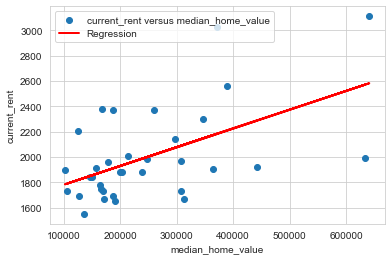

In [87]:
clean_dataset_5[:10]
len(clean_dataset_5)

predict_set=clean_dataset_5[clean_dataset_5['current_rent'].isnull()]
len(predict_set)

model_set=clean_dataset_5[clean_dataset_5['current_rent'].notnull()]
len(model_set)

print('Model set',len(model_set),'Predict set',len(predict_set),'Total set',len(clean_dataset_5))

model_set[:5]

# basic single variable model
y, X = dmatrices('current_rent ~ median_home_value', data=model_set, return_type='dataframe')
model = sm.OLS(y, X)       # Set up the model
result = model.fit()       # Fit model

print('Params')
print(result.params)
print
print('R-squared =', result.rsquared)
print('P-values')
print(result.pvalues)

x = model_set['median_home_value']
y_actual = model_set['current_rent']
y_expected = result.params['Intercept'] + result.params['median_home_value'] * x

scatter(x=x, y=y_actual, label='current_rent versus median_home_value')
plot(x, y_expected, color='red', linewidth=2, label='Regression')
xlabel('median_home_value')
ylabel('current_rent')
legend(loc='best')


#prediction
y_predict = result.params['Intercept'] + result.params['median_home_value'] * clean_dataset_5['median_home_value']
#Add prediction into final dataset for Map
tdf['Predicted_Rent']=y_predict

# Models

## Dataset setup - train and test

In [56]:
# Austin_housing_data_zip_2.columns
# 'hasAssociation', latest_saleyear, 'numOfPhotos'
## 'education_score', 'median_home_value', 'median_household_income', 'current_rent', 'population', 'transport_score', 'numOfSchools'

In [55]:
# Austin_housing_data_zip_2['latestPrice'].describe()

In [88]:
city_vc = Austin_housing_data_zip_2['city'].value_counts()
Austin_housing_data_zip_2 = Austin_housing_data_zip_2[Austin_housing_data_zip_2['city'] == 'austin']
Austin_housing_data_zip_2 = Austin_housing_data_zip_2.reset_index()
Austin_housing_data_zip_2 = Austin_housing_data_zip_2.drop(columns = ['index'])
homeType_vc = Austin_housing_data_zip_2['homeType'].value_counts()
Austin_housing_data_zip_2 = Austin_housing_data_zip_2[(Austin_housing_data_zip_2['homeType'] == 'Single Family') | \
                                              (Austin_housing_data_zip_2['homeType'] == 'Condo') | \
                                              (Austin_housing_data_zip_2['homeType'] == 'Townhouse') | \
                                              (Austin_housing_data_zip_2['homeType'] == 'Multiple Occupancy')]
Austin_housing_data_zip_2 = Austin_housing_data_zip_2.reset_index()
Austin_housing_data_zip_2 = Austin_housing_data_zip_2.drop(columns = ['index'])
Austin_housing_data_zip_2['homeType'] = Austin_housing_data_zip_2['homeType'].apply( lambda x: 1 if x == 'Single Family' \
                                                                else (2 if x == 'Condo' else (3 if x == 'Townhouse' else 4)))

In [104]:
Austin_housing_data_zip_2['education_score_val'] = Austin_housing_data_zip_2['education_score'].apply( lambda x: 1 if x == 'High' \
                                                                else (2 if x == 'Medium' else (3 if x == 'Low' else 4)))
Austin_housing_data_zip_2['transport_score_val'] = Austin_housing_data_zip_2['transport_score'].apply( lambda x: 1 if x == 'High' \
                                                                else (2 if x == 'Medium' else (3 if x == 'Low' else 4)))

('High', 'Medium', 'Low', 'Very Low')

In [111]:
Austin_housing_data_zip_2
Austin_housing_data_zip_2[Austin_housing_data_zip_2.isna().any(axis=1)]

,zpid,city,streetAddress,zipcode,latitude,longitude,propertyTaxRate,garageSpaces,hasCooling,hasGarage,...,numOfStories,education_score,median_home_value,median_household_income,current_rent,population,transport_score,numOfSchools,education_score_val,transport_score_val
5,29462564,austin,14702 Menifee St,78725,30.233154296875,-97.58731842041016,1.98,2,0,0,...,1.0,High,111800.0,52381.0,NaN,6083.0,Low,3.0,1,3
6,70355992,austin,15303 Lucian St,78725,30.23806571960449,-97.57801818847656,1.98,2,0,0,...,1.0,High,111800.0,52381.0,NaN,6083.0,Low,3.0,1,3
8,70355990,austin,15207 Lucian St,78725,30.238237380981445,-97.57833099365234,1.98,2,0,0,...,1.0,High,111800.0,52381.0,NaN,6083.0,Low,3.0,1,3
9,70333917,austin,12525 Verandah Ct,78726,30.426456451416016,-97.85929107666016,1.98,2,0,0,...,2.0,Medium,344700.0,67466.0,NaN,13122.0,High,3.0,2,1
13,145656987,austin,4606 Belfield Ln,78725,30.24176788330078,-97.5790557861328,1.98,0,0,0,...,1.0,High,111800.0,52381.0,NaN,6083.0,Low,3.0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13580,2078228282,austin,724 Spectacular Bid Dr,78737,30.20340347290039,-98.01512908935548,2.01,3,0,0,...,2.0,Medium,338700.0,121094.0,NaN,12081.0,High,3.0,2,1
13581,29333111,austin,2901 Maravillas Loop,78735,30.286211013793945,-97.87088012695312,1.98,3,0,0,...,2.0,Medium,373400.0,79984.0,NaN,16131.0,High,3.0,2,1
14387,29399641,austin,4210 Wilshire Pkwy,78722,30.29762077331543,-97.71209716796876,1.98,3,0,0,...,1.0,High,279200.0,50923.0,NaN,5901.0,Low,3.0,1,3
14391,83827843,austin,10920 Worn Sole Dr,78754,30.367902755737305,-97.65335845947266,1.98,4,0,0,...,2.0,Medium,163000.0,54896.0,NaN,15036.0,Low,4.0,2,3


In [112]:
randomstate = 1
y = Austin_housing_data_zip_2['latestPrice']
X = Austin_housing_data_zip_2[['zipcode', 'longitude', 'propertyTaxRate', 'hasGarage', 'hasSpa', 'hasView', \
       'homeType', 'yearBuilt', 'numOfParkingFeatures', 'numOfWaterfrontFeatures', 'numOfCommunityFeatures', \
       'livingAreaSqFt', 'numOfPrimarySchools', 'numOfElementarySchools', 'numOfMiddleSchools', \
       'numOfHighSchools', 'avgSchoolRating', 'avgSchoolSize', 'numOfBathrooms', 'numOfBedrooms', 'numOfStories',\
       'education_score_val', 'median_home_value', 'median_household_income', \
       'population', 'transport_score_val', 'numOfSchools']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=randomstate)

In [113]:
X_train = X_train.reset_index()
X_train = X_train.drop(columns = ['index'])

X_test = X_test.reset_index()
X_test = X_test.drop(columns = ['index'])

y_train = y_train.reset_index()
y_train = y_train.drop(columns = ['index'])

y_test = y_test.reset_index()
y_test = y_test.drop(columns = ['index'])


## Multiple Linear Regression

In [178]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)
pred = linreg.predict(X_test)
pred_df = DataFrame(pred)
pred_df = pred_df.rename(columns = {0: 'predicted_test'})
pred_df['original_test'] = y_test
pred_df['error'] = (pred_df['original_test'] - pred_df['predicted_test'])
pred_df['error_abs'] = abs(pred_df['error'])
pred = pred_df['error']
pred_df_prod = pred_df['error'] * pred_df['error']

lin_RMSE = math.sqrt(pred_df_prod.abs().mean())

pred
y_test

lin_r2 = r2_score(y_test, pred)
lin_r2


-2.6619264404224823

In [116]:
cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=1)
rfecv_linreg = RFECV(estimator=linreg, step=1, cv=cv, scoring='neg_mean_squared_error')
rfecv_linreg.fit(X_train, y_train)

RFECV(cv=RepeatedKFold(n_repeats=2, n_splits=5, random_state=1),
      estimator=LinearRegression(), scoring='neg_mean_squared_error')

## KNN Regression



Minimum RMSE of 161816.47 at k = 15


<AxesSubplot:>

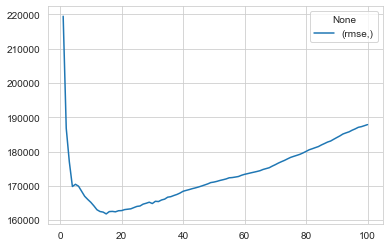

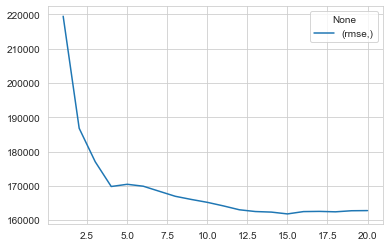

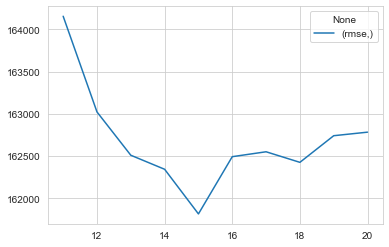

In [119]:
# KNN Regression

# y_train = train['latestPrice']
# X_train = train[['numOfBathrooms', 'livingAreaSqFt', 'numOfBedrooms']]
# X_test = test[['numOfBathrooms', 'livingAreaSqFt', 'numOfBedrooms']]
# y_test = test['latestPrice']

mse_val = [] #to store mae values for different k
rmse_val = []
rmse_df = DataFrame(columns = [['k', 'rmse']])

# checks mean absolute error scores on k from 1 to 20
for K in range(100):
    K = K+1
    # set up the KNN regressor
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(X_train, y_train)  #fit the model
    pred=model.predict(X_test) #make prediction on test set
    error = mean_squared_error(y_test,pred) #calculate rmse
    mse_val.append(error) #store mse values
    error_sqrt = math.sqrt(error)
    rmse_val.append(error_sqrt)
#     print('RMSE value for k = ' , K , 'is:', round(error_sqrt,2))
    
    rmse_df.loc[K] = [K, round(error_sqrt)]
    
# gets optimal k-value based on score minimum
index_min = np.argmin(mse_val) + 1

rmse_min = min(rmse_val)
rmse_index_min = np.argmin(rmse_val) + 1
print("\n")
print(f"Minimum RMSE of {round(rmse_min, 2)} at k = {rmse_index_min}")


# print("\n")
# print("\n")
# print(rmse_df)

# # makes model and fits using optimal k
# model = neighbors.KNeighborsRegressor(n_neighbors = index_min)
# # make_model_log(model, X_train, X_test, y_train, y_test, 'KNN')


# makes model and fits using optimal k
model = neighbors.KNeighborsRegressor(n_neighbors = index_min)
# make_model_log(model, X_train_knn, X_test_knn, y_train_knn, y_test_knn, 'KNN')
rmse_df.plot(y='rmse')
rmse_df.iloc[20:100].plot(y='rmse')
rmse_df.iloc[80:95].plot(y='rmse')

model.fit(X_train_knn, y_train_knn)
pred_y_tree = model.predict(X_test_knn)
cv_5 = cross_val_score(model, X_train_knn, y_train_knn, cv=5)
r2 = round(cv_5.mean()*100,2)
rmse = round(np.sqrt(mean_squared_error(y_test_knn, pred_y_tree)), 2)

new_row = {'Model':'KNN', 'R2':r2, 'RMSE':rmse}
df=df.append(new_row,ignore_index=True)

print('------------------------------------\nRMSE and R2 values KNN: ',rmse,r2)


<AxesSubplot:>

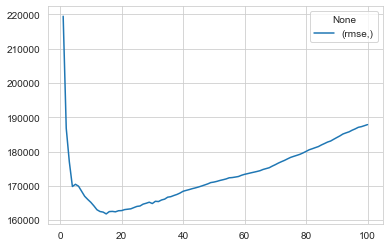

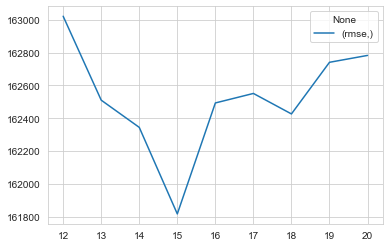

In [121]:
rmse_df.plot(y = 'rmse')
# rmse_df.iloc[0:20].plot(y='rmse')
rmse_df.iloc[11:20].plot(y='rmse')

## Trees

In [122]:
models = {}
models['Decision Tree'] = tree.DecisionTreeRegressor(criterion='squared_error')
models['Bagging'] = BaggingRegressor(tree.DecisionTreeRegressor(criterion='squared_error'), random_state=1)
models['Random Forest'] = RandomForestRegressor(n_estimators=8, random_state=1)
models['Gradient Boosting'] = GradientBoostingRegressor(n_estimators=200, max_depth=4, random_state=1)

In [123]:
trees_df = DataFrame(columns = ['Decision Tree', 'Bagging', 'Random Forest', 'Gradient Boosting'])
tree_iter = 0

y_pred_r2_list = []

for name, model in models.items():
    tree_iter = tree_iter + 1
    
    model.fit(X_train, y_train)
    pred_y_tree = model.predict(X_test)
    pred_y_tree_Series = Series(pred_y_tree)
    
    if tree_iter == 1:
        trees_df['Decision Tree'] = round(pred_y_tree_Series,2)
    elif tree_iter == 2:
        trees_df['Bagging'] = round(pred_y_tree_Series,2)
    elif tree_iter == 3:
        trees_df['Random Forest'] = round(pred_y_tree_Series,2)
    elif tree_iter == 4:
        trees_df['Gradient Boosting'] = round(pred_y_tree_Series,2)
    
    y_pred_r2_list.append(round(r2_score(y_test, pred_y_tree_Series),4))

data = [['Decision Tree R2', y_pred_r2_list[0]], ['Bagging', y_pred_r2_list[1]], \
        ['Random Forest', y_pred_r2_list[2]], ['Gradient Boosting', y_pred_r2_list[3]]]
y_pred_param_df = DataFrame(data, columns = ['Tree Type', 'R2'])
y_pred_param_df = y_pred_param_df.set_index('Tree Type')
print(y_pred_param_df)

trees_df['y_test'] = y_test
trees_df['Decision Tree Error'] = trees_df['Decision Tree'] - trees_df['y_test']
trees_df['Bagging Error'] = trees_df['Bagging'] - trees_df['y_test']
trees_df['Random Forest Error'] = trees_df['Random Forest'] - trees_df['y_test']
trees_df['Gradient Boosting Error'] = trees_df['Gradient Boosting'] - trees_df['y_test']
trees_df = trees_df.round(2)

    

                       R2
Tree Type                
Decision Tree R2   0.5902
Bagging            0.7592
Random Forest      0.7541
Gradient Boosting  0.7793


In [124]:
# Decision Tree Error
dec_tree_sq = trees_df['Decision Tree Error']*trees_df['Decision Tree Error']
dec_tree_sq_mean = dec_tree_sq.mean()
dec_tree_rmse = math.sqrt(dec_tree_sq_mean)
print('RMSE for Decision Tree:', round(dec_tree_rmse,2))

# Bagging Error
bag_tree_sq = trees_df['Bagging Error']*trees_df['Bagging Error']
bag_tree_sq_mean = bag_tree_sq.mean()
bag_tree_rmse = math.sqrt(bag_tree_sq_mean)
print('RMSE for Bagging:', round(bag_tree_rmse,2))

# Random Forest Error
rf_tree_sq = trees_df['Random Forest Error']*trees_df['Random Forest Error']
rf_tree_sq_mean = rf_tree_sq.mean()
rf_tree_rmse = math.sqrt(rf_tree_sq_mean)
print('RMSE for Random Forest:', round(rf_tree_rmse,2))

# Gradient Boosting Error
grad_boost_tree_sq = trees_df['Gradient Boosting Error']*trees_df['Gradient Boosting Error']
grad_boost_tree_sq_mean = grad_boost_tree_sq.mean()
grad_boost_tree_rmse = math.sqrt(grad_boost_tree_sq_mean)
print('RMSE for Gradient Boosting:', round(grad_boost_tree_rmse,2))

y_pred_param_df['RMSE'] = [round(dec_tree_rmse,2), round(bag_tree_rmse,2), round(rf_tree_rmse,2), round(grad_boost_tree_rmse,2)]
y_pred_param_df

RMSE for Decision Tree: 206540.53
RMSE for Bagging: 158315.84
RMSE for Random Forest: 159991.31
RMSE for Gradient Boosting: 151587.36


,R2,RMSE
Tree Type,,
Decision Tree R2,0.5902,206540.53
Bagging,0.7592,158315.84
Random Forest,0.7541,159991.31
Gradient Boosting,0.7793,151587.36


In [125]:
print("\n\nDecision Tree")
X = X_train
y = y_train
# define the model
model = tree.DecisionTreeRegressor()
# evaluate the model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
print(type(n_scores))
n_scores = n_scores.astype(float)
print(n_scores)
print(n_scores/1000000)
print(len(n_scores))
print(type(n_scores))
# report performance
print('MSE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
mse_tree = mean(n_scores)
mse_tree_root = math.sqrt(abs(mse_tree))
print("mse_tree:", mse_tree)
print('RMSE: ', round(mse_tree_root,2))

print("\n\nBagging")
X = X_train
y = y_train
# define the model
model = BaggingRegressor(
        tree.DecisionTreeRegressor(criterion='squared_error'),
        random_state=1)
# evaluate the model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
print(type(n_scores))
n_scores = n_scores.astype(float)
print(n_scores)
print(n_scores/1000000)
print(len(n_scores))
print(type(n_scores))
# report performance
print('MSE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
mse_bagging = mean(n_scores)
mse_bagging_root = math.sqrt(abs(mse_bagging))
print("mse_bagging:", mse_bagging)
print('RMSE: ', round(mse_bagging_root,2))

print("\n\nRF")
X = X_train
y = y_train
# define the model
model = RandomForestRegressor()
# evaluate the model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
print(type(n_scores))
n_scores = n_scores.astype(float)
print(n_scores)
print(n_scores/1000000)
print(len(n_scores))
print(type(n_scores))
# report performance
print('MSE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
mse_rf = mean(n_scores)
mse_rf_root = math.sqrt(abs(mse_rf))
print("mse_bagging:", mse_rf)
print('RMSE: ', round(mse_rf_root,2))

print("\n\n")
X = X_train
y = y_train
# define the model
model = GradientBoostingRegressor()
# evaluate the model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
print(type(n_scores))
n_scores = n_scores.astype(float)
print(n_scores)
print(n_scores/1000000)
print(len(n_scores))
print(type(n_scores))
# report performance
print('MSE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
mse_bagging = mean(n_scores)
mse_bagging_root = math.sqrt(abs(mse_bagging))
print("mse_bagging:", mse_bagging)
print('RMSE: ', round(mse_bagging_root,2))



Decision Tree
<class 'numpy.ndarray'>
[-5.38557263e+10 -5.89031138e+10 -6.36992987e+10 -5.23655967e+10
 -5.05242797e+10 -3.69355787e+10 -4.69333369e+10 -3.82907446e+10
 -6.38302230e+10 -3.92085472e+10 -4.25261206e+10 -5.12886196e+10
 -4.15936785e+10 -6.16253637e+10 -5.02135111e+10 -6.33888693e+10
 -5.18624956e+10 -5.44390086e+10 -5.53945605e+10 -3.66028820e+10
 -5.17679943e+10 -5.26851204e+10 -5.15861218e+10 -4.81660627e+10
 -4.64693255e+10 -4.20512351e+10 -4.67267514e+10 -4.95388066e+10
 -4.81285026e+10 -4.52677597e+10]
[-53855.72634758 -58903.1138045  -63699.2987043  -52365.59674602
 -50524.2797335  -36935.57872998 -46933.33687535 -38290.74456023
 -63830.22302839 -39208.54724297 -42526.12055209 -51288.61963619
 -41593.67846184 -61625.36374783 -50213.5110653  -63388.86928703
 -51862.49556306 -54439.00861958 -55394.56051845 -36602.88199493
 -51767.99428021 -52685.12035115 -51586.12180872 -48166.06266815
 -46469.32547673 -42051.23507791 -46726.75143561 -49538.80657416
 -48128.50264109

### Decision Trees

In [148]:
# Create the folds in the training data
kfold = StratifiedKFold(n_splits=3, shuffle=True)

scores_dec_list = []
rmse_dec_list = []
dec_tree_y_pred_r2_list = []

# Iterate over max_depth
for max_depth in [1, 2, 3, 4, 5]:
    model3 = tree.DecisionTreeRegressor(criterion='squared_error', max_depth=max_depth, random_state=1)
    
    model3.fit(X_train, y_train)
    prediction_test = model3.predict(X_test)
    prediction_test_df = DataFrame(prediction_test)
    dec_tree_error_df = prediction_test_df[0] - y_test['latestPrice']
    
    dec_tree_y_pred_r2_list.append(round(r2_score(y_test, prediction_test),4))
    
    dec_tree_error_sq_df = dec_tree_error_df * dec_tree_error_df
    dec_tree_error_rmse = math.sqrt(dec_tree_error_sq_df.mean())
    # print("\n\ndec_tree_error_rmse: ", dec_tree_error_rmse)
    rmse_dec_list.append(dec_tree_error_rmse)
    
    scores = cross_val_score(model3, X_train, y_train, cv=kfold, scoring='neg_root_mean_squared_error')
    scores_dec_list.append(scores)
    # print('max_depth={} scores={} avg_score={}    std_dev = {}'.format(max_depth, scores, scores.mean(), scores.std()))


print(dec_tree_y_pred_r2_list)
dec_tree_y_pred_r2_df = DataFrame(data = [[1, 2, 3, 4, 5], dec_tree_y_pred_r2_list])
dec_tree_y_pred_r2_df = dec_tree_y_pred_r2_df.rename(columns = {0: "1", 1: "2", 2: "3", 3: "4", 4: "5"})
dec_tree_y_pred_r2_df = dec_tree_y_pred_r2_df.T
dec_tree_y_pred_r2_df = dec_tree_y_pred_r2_df.rename(columns = {0: "max_depth", 1: "r2"})
dec_tree_best_r2 = dec_tree_y_pred_r2_df["r2"].max()
dec_tree_y_pred_r2_df.loc[dec_tree_y_pred_r2_df["r2"].idxmax()]
dec_tree_best_r2_maxdepth = dec_tree_y_pred_r2_df.loc[dec_tree_y_pred_r2_df["r2"].idxmax()]["max_depth"]

print(f"Decision Tree: best R2 of {dec_tree_best_r2} at best max tree depth of {dec_tree_best_r2_maxdepth}")


scores_dec_df = DataFrame(scores_dec_list)
scores_dec_df = scores_dec_df.T
scores_dec_df = scores_dec_df.rename(columns = {0: "1", 1: "2", 2: "3", 3: "4", 4: "5"})
scores_dec_df.loc[3] = [scores_dec_df["1"].abs().mean(), scores_dec_df["2"].abs().mean(), scores_dec_df["3"].abs().mean(), scores_dec_df["4"].abs().mean(), scores_dec_df["5"].abs().mean()]
scores_dec_df = scores_dec_df.T
scores_dec_df = scores_dec_df.rename(columns = {3: "mean"})

# RMSE of StratifiedKFold Cross Validation of Decison Tree
opt_rmse_dec_tree = round(scores_dec_df["mean"].abs().min(),2)
opt_depth_dec_tree = scores_dec_df["mean"].abs().idxmin()
opt_depth_dec_tree = int(opt_depth_dec_tree)
opt_rmse_dec_tree = abs(round(scores_dec_df["mean"][scores_dec_df["mean"].abs().idxmin()],2))





[0.3108, 0.495, 0.5639, 0.6399, 0.6725]
Decision Tree: best R2 of 0.6725 at best max tree depth of 5.0


### Bagging

In [149]:
scores_bag_list = []

for num_trees in [100, 200, 300, 400, 500]:
    model = BaggingRegressor(tree.DecisionTreeRegressor(criterion='squared_error', max_depth=opt_depth_dec_tree, random_state=1),
                             n_estimators=num_trees, random_state=1)
    # max_depth=opt_depth_dec_tree ... from StratifiedKFold Cross Validation of Decison Tree ... to confirm!
    model.fit(X_train, y_train)
    prediction_test = model.predict(X_test)
    
    scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_root_mean_squared_error')
    scores_bag_list.append(scores)
    # print('max_depth={} scores={} avg_score={}    std_dev = {}'.format(max_depth, scores, scores.mean(), scores.std()))

scores_bag_df = DataFrame(scores_bag_list)
scores_bag_df = scores_bag_df.T
scores_bag_df = scores_bag_df.rename(columns = {0: "100", 1: "200", 2: "300", 3: "400", 4: "500"})
scores_bag_df.loc[3] = [scores_bag_df["100"].abs().mean(), scores_bag_df["200"].abs().mean(), scores_bag_df["300"].abs().mean(), scores_bag_df["400"].abs().mean(), scores_bag_df["500"].abs().mean()]
scores_bag_df = scores_bag_df.T
scores_bag_df = scores_bag_df.rename(columns = {3: "mean"})

opt_rmse_bag_tree = round(scores_bag_df["mean"].abs().min(),2)
opt_numtree_bag_tree = scores_bag_df["mean"].abs().idxmin()
opt_numtree_bag_tree = int(opt_numtree_bag_tree)
opt_rmse_bag_tree = abs(round(scores_bag_df["mean"][scores_bag_df["mean"].abs().idxmin()],2))


In [180]:
# Create the folds in the training data
kfold = StratifiedKFold(n_splits=3, shuffle=True)

scores_bag_list = []
rmse_bag_list = []

# Iterate over max_depth
for max_depth in [1, 2, 3, 4, 5]:
    model3 = BaggingRegressor(tree.DecisionTreeRegressor(criterion='squared_error', max_depth=max_depth, random_state=1),
                             n_estimators=opt_numtree_bag_tree, random_state=1)
    
    model3.fit(X_train, y_train)
    prediction_test = model3.predict(X_test)
    prediction_test_df = DataFrame(prediction_test)
    bag_tree_error_df = prediction_test_df[0] - y_test['latestPrice']
    
    bag_tree_error_sq_df = bag_tree_error_df * bag_tree_error_df
#     print(bag_tree_error_sq_df)
    bag_tree_error_rmse = math.sqrt(bag_tree_error_sq_df.mean())
#     print("\n\nbag_tree_error_rmse: ", bag_tree_error_rmse)
    rmse_bag_list.append(bag_tree_error_rmse)
    
    scores = cross_val_score(model3, X_train, y_train, cv=kfold, scoring='neg_root_mean_squared_error')
    scores_bag_list.append(scores)
#     print('max_depth={} scores={} avg_score={}    std_dev = {}'.format(max_depth, scores, scores.mean(), scores.std()))

rmse_bag_df = DataFrame(rmse_bag_list)
rmse_bag_df = rmse_bag_df.rename(columns = {0: 'rmse'})
rmse_bag_df = rmse_bag_df.T
rmse_bag_df = rmse_bag_df.rename(columns = {0: "1", 1: "2", 2: "3", 3: "4", 4: "5"})
rmse_bag_df = rmse_bag_df.T

rmse_max_depth_bag_tree = round(rmse_bag_df['rmse'].min(),2)
max_depth_bag_tree = rmse_bag_df['rmse'].idxmin()
max_depth_bag_tree
opt_max_depth_bag_tree = int(max_depth_bag_tree)

# Bagging: With optimized parameters:
model3 = BaggingRegressor(tree.DecisionTreeRegressor(criterion='squared_error', max_depth=opt_max_depth_bag_tree, random_state=1),
                             n_estimators=opt_numtree_bag_tree, random_state=1)
    
model3.fit(X_train, y_train)
prediction_test = model3.predict(X_test)

prediction_test_df = DataFrame(prediction_test)
bag_tree_error_df = prediction_test_df - y_test
bag_tree_y_pred_r2 = round(r2_score(y_test, prediction_test),4)
print(bag_tree_y_pred_r2)

print(f"Bagging: R2 of {bag_tree_y_pred_r2} after optimization at best num tree of {opt_numtree_bag_tree} \
and best max tree depth of {opt_max_depth_bag_tree}")

0.7204
Bagging: R2 of 0.7204 after optimization at best num tree of 100 and best max tree depth of 5


### Random Forests

In [156]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(2, 5, num = 5)]
bootstrap = [True]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'bootstrap': bootstrap}

# Random Forest Optimization
opt_rf = RandomForestRegressor()

rf_random = RandomizedSearchCV(estimator = opt_rf, param_distributions = random_grid, scoring='neg_root_mean_squared_error', n_iter = 25, cv = 3, verbose=10, random_state=1)
rf_random.fit(X_train, y_train)
rf_random.best_estimator_

print("Best parameters set found on train set: \n")
print(rf_random.best_params_)
print("\nS scores on train set:\n")
means = rf_random.cv_results_['mean_test_score']
stds = rf_random.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, rf_random.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

rf_random.best_params_
rf_opt_numtree = rf_random.best_params_['n_estimators']
rf_opt_maxdepth = rf_random.best_params_['max_depth']


Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV 1/3; 1/25] START bootstrap=True, max_depth=3, max_features=sqrt, n_estimators=300
[CV 1/3; 1/25] END bootstrap=True, max_depth=3, max_features=sqrt, n_estimators=300;, score=-221234.178 total time=   0.7s
[CV 2/3; 1/25] START bootstrap=True, max_depth=3, max_features=sqrt, n_estimators=300
[CV 2/3; 1/25] END bootstrap=True, max_depth=3, max_features=sqrt, n_estimators=300;, score=-225098.356 total time=   0.6s
[CV 3/3; 1/25] START bootstrap=True, max_depth=3, max_features=sqrt, n_estimators=300
[CV 3/3; 1/25] END bootstrap=True, max_depth=3, max_features=sqrt, n_estimators=300;, score=-230836.387 total time=   0.7s
[CV 1/3; 2/25] START bootstrap=True, max_depth=4, max_features=sqrt, n_estimators=100
[CV 1/3; 2/25] END bootstrap=True, max_depth=4, max_features=sqrt, n_estimators=100;, score=-206004.329 total time=   0.2s
[CV 2/3; 2/25] START bootstrap=True, max_depth=4, max_features=sqrt, n_estimators=100
[CV 2/3; 2/25] EN

[CV 1/3; 14/25] END bootstrap=True, max_depth=4, max_features=sqrt, n_estimators=200;, score=-205040.806 total time=   0.4s
[CV 2/3; 14/25] START bootstrap=True, max_depth=4, max_features=sqrt, n_estimators=200
[CV 2/3; 14/25] END bootstrap=True, max_depth=4, max_features=sqrt, n_estimators=200;, score=-203145.926 total time=   0.5s
[CV 3/3; 14/25] START bootstrap=True, max_depth=4, max_features=sqrt, n_estimators=200
[CV 3/3; 14/25] END bootstrap=True, max_depth=4, max_features=sqrt, n_estimators=200;, score=-211264.494 total time=   0.5s
[CV 1/3; 15/25] START bootstrap=True, max_depth=2, max_features=sqrt, n_estimators=500
[CV 1/3; 15/25] END bootstrap=True, max_depth=2, max_features=sqrt, n_estimators=500;, score=-245928.003 total time=   1.0s
[CV 2/3; 15/25] START bootstrap=True, max_depth=2, max_features=sqrt, n_estimators=500
[CV 2/3; 15/25] END bootstrap=True, max_depth=2, max_features=sqrt, n_estimators=500;, score=-250326.561 total time=   0.9s
[CV 3/3; 15/25] START bootstrap=

In [163]:
# Random Forest: With optimized parameters:

model3 = RandomForestRegressor(criterion='squared_error', max_depth=rf_opt_maxdepth, n_estimators=rf_opt_numtree, random_state=1)

model3.fit(X_train, y_train)
prediction_test = model3.predict(X_test)

prediction_test_df = DataFrame(prediction_test)
rf_tree_error_df = prediction_test_df[0] - y_test['latestPrice']
rf_tree_y_pred_r2 = round(r2_score(y_test, prediction_test),4)

rf_tree_error_sq_df = rf_tree_error_df * rf_tree_error_df
rf_tree_error_rmse = round(math.sqrt(rf_tree_error_sq_df.mean()),2)
print("\n\nrf_tree_error_rmse: ", rf_tree_error_rmse)

print(f"Random forest: R2 of {rf_tree_y_pred_r2} after optimization at best num tree of {rf_opt_numtree} \
and best max tree depth of {rf_opt_maxdepth}")



rf_tree_error_rmse:  170665.78
Random forest: R2 of 0.7202 after optimization at best num tree of 100 and best max tree depth of 5


In [162]:
print("For Decision Trees:")
print(f"RMSE of {opt_rmse_dec_tree} for max depth of {opt_depth_dec_tree}")
print("\n")

print("For Bagging:")
print(f"RMSE of {opt_rmse_bag_tree} for max number of trees at {opt_numtree_bag_tree}")
print(f"RMSE of {rmse_max_depth_bag_tree} for max number of trees at {opt_numtree_bag_tree} and max depth of {max_depth_bag_tree}")







For Decision Trees:
RMSE of 203170.68 for max depth of 5


For Bagging:
RMSE of 180763.01 for max number of trees at 100
RMSE of 170605.71 for max number of trees at 100 and max depth of 5


In [179]:
y_pred_param_df_final = y_pred_param_df.rename(columns = {"R2": "Pre-Optimized R2", "RMSE": "Pre-Optimized RMSE"})
y_pred_param_df_final["Post-Optimized R2"] = [dec_tree_best_r2, bag_tree_y_pred_r2, rf_tree_y_pred_r2, ""]
y_pred_param_df_final["Post-Optimized RMSE"] = [opt_rmse_dec_tree, rmse_max_depth_bag_tree, rf_tree_error_rmse, ""]
y_pred_param_df_final["Pre-Optimized R2"] = y_pred_param_df_final["Pre-Optimized R2"] * 100
y_pred_param_df_final["Post-Optimized R2"] = y_pred_param_df_final["Post-Optimized R2"] * 100
y_pred_param_df_final['NumTrees'] = ["", opt_numtree_bag_tree, rf_opt_numtree,""]
y_pred_param_df_final['MaxDepth'] = [opt_depth_dec_tree, opt_max_depth_bag_tree, rf_opt_maxdepth,""]
y_pred_param_df_final

,Pre-Optimized R2,Pre-Optimized RMSE,Post-Optimized R2,Post-Optimized RMSE,NumTrees,MaxDepth
Tree Type,,,,,,
Decision Tree R2,59.02,206540.53,67.25,203170.68,,5
Bagging,75.92,158315.84,72.04,170605.71,100,5
Random Forest,75.41,159991.31,72.02,170665.78,100,5
Gradient Boosting,77.93,151587.36,,,,


***

## Final Step : Getting Details into the Map

In [27]:
#Getting Details into the Map
import folium
from folium.plugins import MarkerCluster # for clustering the markers
map = folium.Map(location=[30.266666, -97.733330], default_zoom_start=15)
folium.Choropleth(
    geo_data="Boundaries_ Zip Code Tabulation Areas, 2017.geojson",
    data=tdf, 
    columns=['zipcode', 'Predicted_Rent'], 
    key_on='feature.properties.geoid10', 
    fill_color='YlGnBu',fill_opacity=0.5,line_opacity=0.7,
    legend_name='Predicted Rent'
).add_to(map)

from uszipcode import SearchEngine
engine = SearchEngine()

highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}

# add a marker for every record in the filtered data, use a clustered view
marker_cluster = MarkerCluster().add_to(map) # create marker clusters
for i in range(tdf.shape[0]):
    zipcode = engine.by_zipcode(tdf["zipcode"][i])
    location = [zipcode.lat,zipcode.lng]
    highlight_function=highlight_function
    tooltip = "Zipcode:{}<br> <b>Mean Predicted Home Value: ${:,}</b><br> Click for more".format(tdf["zipcode"][i], np.float64(round(tdf['Predicted_Rent'][i],2)))
    iframe = folium.IFrame("""<i>Mean Predicted Home Value: </i>  <b><FONT COLOR="RED">${:,}</FONT></b> <br>
                  <i>Mean Current Home Value: </i><b>${:,}</b><br>
                  <i>Mean Current Rent: </i><b>${:,}</b><br>
                  <i>Median Home Value: </i><b><FONT COLOR="GREEN">${:,}</FONT></b><br>
                  <br><b>Statistics for this ZIP Code ----------------------------</b><br>
                  <i>Population: </i><b>{:,}</b><br>
                  <i>Education Attainment: </i><b><FONT COLOR="BLUE">{}</FONT></b><br>
                  <i>Median Household Income: </i><b>${:,}</b><br>
                  <i>Access to Public Transport: </i><b><FONT COLOR="BLUE">{}</FONT></b><br>
                  <br><b>Houses you should buy ----------------------------</b><br>
                  <i>The 5 most affordable houses: </i><b>{}</b><br>""".format(np.float64(round(tdf['current_rent'][i],2)), 
                                                                                np.float64(round(tdf['current_rent'][i],2)),
                                                                                np.float64(round(tdf['current_rent'][i],2)),
                                                                                np.float64(zipcode.median_home_value),
                                                                                np.float64(zipcode.population),
                                                                                tdf['education_score'][i],
                                                                                np.float64(zipcode.median_household_income),
                                                                                tdf['transport_score'][i],
                                                                                df_rent[df_rent['zip']==tdf["zipcode"][i]][['Home Type','Number of Units']].to_html()))
    popup = folium.Popup(iframe, min_width=600, max_width=600)
    folium.Marker(location, popup=popup,tooltip=tooltip).add_to(marker_cluster)
    
    

map

___________________________________________________________________________________________________________________________
## The map of top 50 units you should consider buying

In [28]:
#Plot affordable housing units as an overlay

def plotDot(point):
    '''input: series that contains a numeric named latitude and a numeric named longitude
    this function creates a CircleMarker and adds it to your this_map'''
    folium.CircleMarker(location=[point.latitude, point.longitude],
                        radius=10,
                        weight=0.7,color ='red', fill=True,fill_color='Orange',fill_opacity=0.7,
                        tooltip='<b>Predicted Price : ${:,}</b>'.format(np.float64(point.latestPrice))).add_to(map)

#use df.apply(,axis=1) to "iterate" through every row in your dataframe
Austin_housing_data_zip_clean.sort_values(by='latestPrice', ascending=False)[:50].apply(plotDot, axis = 1)

map

# ---------------------------------------------------------------------------------------------------------------